In [8]:
import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as pl
from matplotlib import rcParams

from pymc_utils import PyMCModel

In [6]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [17]:
def bayes_nn_model(X, y_obs, n_hidden, ylabel='y'):
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    num_obs, num_feats = X.shape
    with pm.Model() as nn_3l:
        w1 = pm.Normal('w_lyr1', mu=0, sd=1, shape=(X.shape[1], n_hidden))
        w2 = pm.Normal('w_lyr2', mu=0, sd=1, shape=(n_hidden, n_hidden))
        w3 = pm.Normal('w_lyr3', mu=0, sd=1, shape=(n_hidden, 1))
        
        b1 = pm.Normal('b_lyr1', mu=0, sd=1, shape=(n_hidden,))
        b2 = pm.Normal('b_lyr2', mu=0, sd=1, shape=(n_hidden,))
        b3 = pm.Normal('b_lyr3', mu=0, sd=1, shape=(1,))
        
        lyr1_out = pm.Deterministic('lyr1_out', tt.nnet.relu(tt.dot(X, w1) + b1))
        lyr2_out = pm.Deterministic('lyr2_out', tt.nnet.relu(tt.dot(lyr1_out, w2) + b2))
        lyr3_out = pm.Deterministic('lyr3_out', tt.dot(lyr2_out, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal('likelihood', mu=lyr3_out, sd=sd, observed=Y)
    return nn_3l

In [7]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_noInteractions.pkl')

In [10]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().log10_chl

In [11]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

In [13]:
type(y_train)

pandas.core.series.Series

In [18]:
bayes_net = PyMCModel(bayes_nn_model, X_s_train, y_train, n_hidden=64)

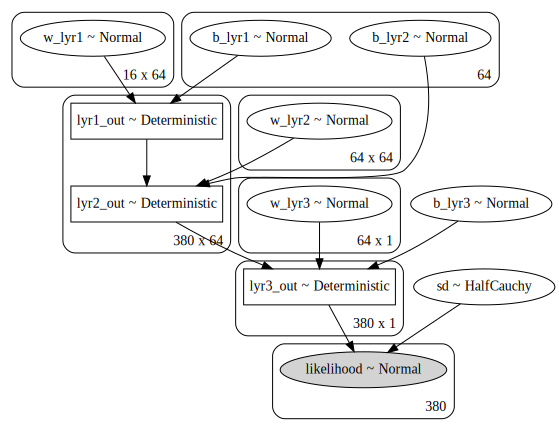

In [19]:
bayes_net.show_model()